In [1]:
# Install PYGAD
!pip install pygad
!pip install pygad plotly

In [2]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from joblib import parallel_backend
import pygad
import plotly.graph_objects as go
import time
import seaborn as sns

2024-05-22 22:01:44.913759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Image directory paths
data_dir = '/Users/albertwv/Desktop/2_Semester/ACI/brain_tumor'

In [4]:
# Load and preprocess images
batch_size = 32
img_size = (224, 224)

train_dataset = image_dataset_from_directory(
    directory=os.path.join(data_dir, 'Training'),
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True)

test_dataset = image_dataset_from_directory(
    directory=os.path.join(data_dir, 'Testing'),
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [5]:
# Configure datasets for performance
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Load pre-trained EfficientNet B0 model
model_path = '/Users/albertwv/Desktop/2_Semester/ACI/model_enb0.h5'
pretrained_model = load_model(model_path)
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1

In [7]:
# Use EfficientNetB0 model as feature extractor
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[2].output)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0_input (Inpu  [(None, 224, 224, 3)]     0         
 tLayer)                                                         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
Total params: 4054691 (15.47 MB)
Trainable params: 4010108 (15.30 MB)
Non-trainable params: 44583 (174.16 KB)
_________________

In [8]:
# Extract features using batches
def extract_features(dataset):
    start_time = time.time()
    all_features = []
    all_labels = []
    for images, labels in dataset:
        features = feature_extractor.predict(images)
        all_features.append(features)
        all_labels.append(labels.numpy())
    all_features = np.concatenate(all_features)
    all_labels = np.concatenate(all_labels)
    end_time = time.time()
    print(f"Feature extraction took: {end_time - start_time:.2f} seconds")
    return all_features, all_labels

train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)

1/1 [==============================] - 3s 3s/step
Feature extraction took: 306.13 seconds
1/1 [==============================] - 1s 1s/step
Feature extraction took: 68.31 seconds


In [9]:
# Scale features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [10]:
# Setting up Genetic Algorithm for SVM Hyperparameter Tuning
best_fitness_values = []

def fitness_func(ga_instance, solution, solution_idx):
    C = solution[0]
    gamma = solution[1]
    svm_classifier = SVC(kernel='rbf', C=C, gamma=gamma, class_weight='balanced')
    svm_classifier.fit(train_features, train_labels)
    predictions = svm_classifier.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

In [11]:
from IPython.display import display, clear_output

In [12]:
# Collect fitness values for plotting
def on_generation(ga_instance):
    best_fitness_values.append(ga_instance.best_solution()[1])
    print(f"Generation {ga_instance.generations_completed}: Best Fitness = {ga_instance.best_solution()[1]}")

    # Update plot
    clear_output(wait=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=list(range(len(best_fitness_values))),
        y=best_fitness_values,
        mode='lines+markers',
        name='Best Fitness'
    ))
    fig.update_layout(
        title="Genetic Algorithm Optimization of SVM Hyperparameters",
        xaxis_title="Generation",
        yaxis_title="Best Fitness (Accuracy)",
        template="plotly_dark"
    )
    display(fig)

    # Add delay if needed
    time.sleep(1)  # 1-second delay after each generation #this might slow down the genetic algorythm after PYGAD 3.3.0

In [13]:
# Defining Genetic Algorithm
ga_instance = pygad.GA(
    num_generations=30, 
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=10,
    num_genes=2,
    init_range_low=0.1,
    init_range_high=10.0,
    mutation_percent_genes=50,  
    gene_type=float,
    gene_space=[{'low': 0.1, 'high': 10.0}, {'low': 0.0001, 'high': 1.0}],
    on_generation=on_generation
)

/Users/albertwv/miniconda3/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [14]:
# Run the Genetic Algorithm
ga_instance.run()

In [15]:
# Get the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best solution: C={solution[0]}, gamma={solution[1]}, accuracy={solution_fitness}")

Best solution: C=4.872427991277531, gamma=0.0001, accuracy=0.9816933638443935


In [16]:
# Evaluate the best solution
best_C = solution[0]
best_gamma = solution[1]
best_svm = SVC(kernel='rbf', C=best_C, gamma=best_gamma, class_weight='balanced')
best_svm.fit(train_features, train_labels)

SVC(C=4.872427991277531, class_weight='balanced', gamma=0.0001)

In [17]:
# Predictions and evaluation
train_predictions = best_svm.predict(train_features)
test_predictions = best_svm.predict(test_features)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9991
Test Accuracy: 0.9817


Confusion Matrix:
 [[289  10   0   1]
 [  5 295   3   3]
 [  0   0 405   0]
 [  0   2   0 298]]


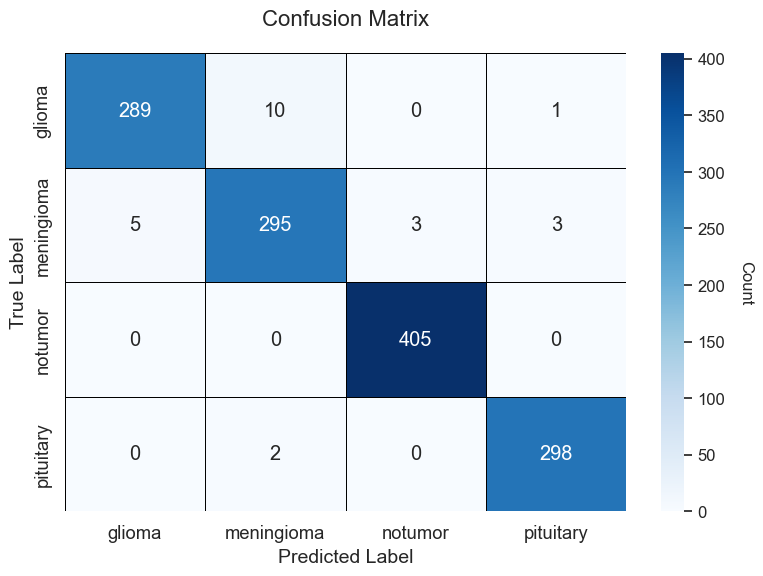

In [18]:
# Sample class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Generate the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust to make the text larger
ax = sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='black')

# Labels and titles
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16, pad=20)

# Customize color bar
colorbar = ax.collections[0].colorbar
colorbar.set_label('Count', rotation=270, labelpad=20, fontsize=12)
colorbar.ax.tick_params(labelsize=12)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
# Sample class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
class_report = classification_report(test_labels, test_predictions, target_names=class_names)
print("Classification Report:\n", class_report)

# Calculate overall accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Parse the classification report to extract individual metrics
report_dict = classification_report(test_labels, test_predictions, target_names=class_names, output_dict=True)

# Iterate over each class and print detailed metrics
for class_name in class_names:
    class_metrics = report_dict[class_name]
    print(f"Class: {class_name}")
    print(f" Precision: {class_metrics['precision']:.4f}")
    print(f" Recall: {class_metrics['recall']:.4f}")
    print(f" F1-Score: {class_metrics['f1-score']:.4f}")

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       300
  meningioma       0.96      0.96      0.96       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Accuracy: 0.9817
Class: glioma
 Precision: 0.9830
 Recall: 0.9633
 F1-Score: 0.9731
Class: meningioma
 Precision: 0.9609
 Recall: 0.9641
 F1-Score: 0.9625
Class: notumor
 Precision: 0.9926
 Recall: 1.0000
 F1-Score: 0.9963
Class: pituitary
 Precision: 0.9868
 Recall: 0.9933
 F1-Score: 0.9900


In [20]:
# Plotting the GA performance with animation
frames = [go.Frame(data=[go.Scatter(
    x=list(range(generation+1)),
    y=best_fitness_values[:generation+1],
    mode='lines+markers',
    name='Best Fitness'
)]) for generation in range(len(best_fitness_values))]

fig = go.Figure(
    data=[go.Scatter(x=[0], y=[best_fitness_values[0]], mode='lines+markers', name='Best Fitness')],
    frames=frames
)

fig.update_layout(
    title="Genetic Algorithm Optimization of SVM Hyperparameters",
    xaxis_title="Generation",
    yaxis_title="Best Fitness (Accuracy)",
    template="plotly_dark",
    updatemenus=[{
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 100, "redraw": True}, "fromcurrent": True}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }]
)

fig.show()

In [21]:
import umap

/Users/albertwv/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


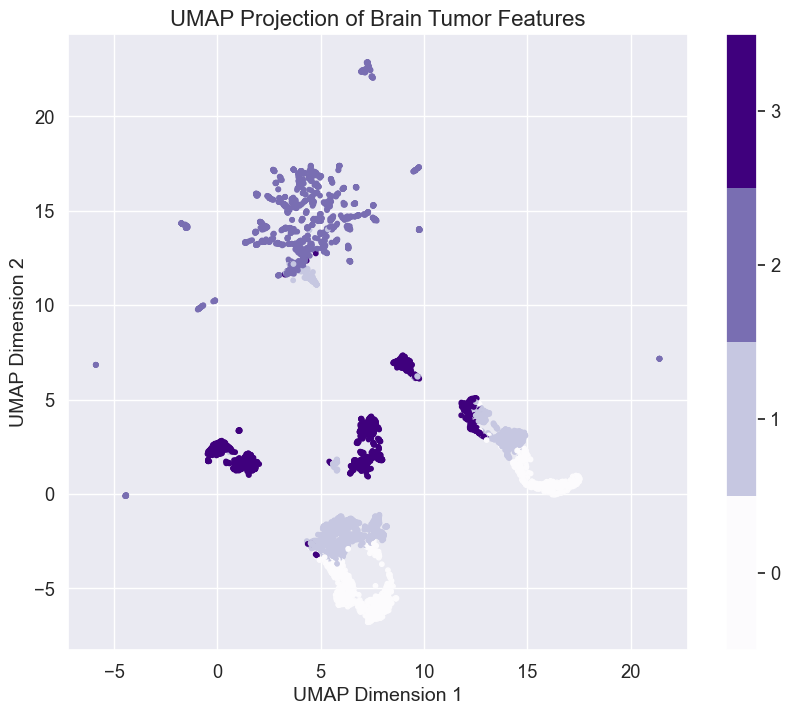

In [22]:
# UMAP Visualization
# Initialize UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(train_features)

# Plot UMAP results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_features[:, 0], umap_features[:, 1], c=train_labels, cmap='Purples', s=10)
plt.colorbar(scatter, boundaries=np.arange(len(class_names) + 1) - 0.5).set_ticks(np.arange(len(class_names)))
plt.title('UMAP Projection of Brain Tumor Features', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(True)
plt.show()

/Users/albertwv/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



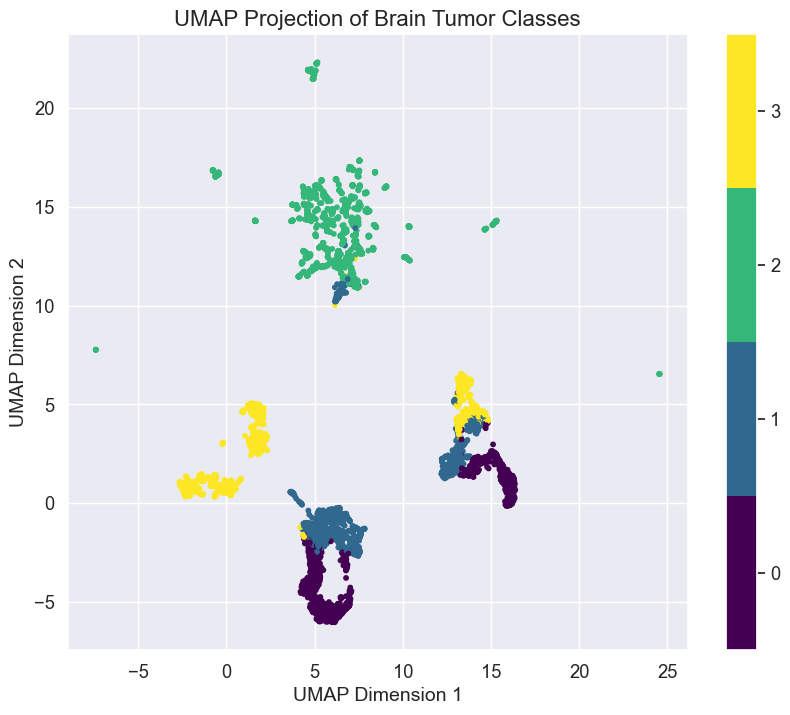

In [23]:
# UMAP Visualization for classes
umap_model_classes = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_classes = umap_model_classes.fit_transform(train_features)

# Plot UMAP results for classes
plt.figure(figsize=(10, 8))
scatter_classes = plt.scatter(umap_classes[:, 0], umap_classes[:, 1], c=train_labels, cmap='viridis', s=10)
plt.colorbar(scatter_classes, boundaries=np.arange(len(class_names) + 1) - 0.5).set_ticks(np.arange(len(class_names)))
plt.title('UMAP Projection of Brain Tumor Classes', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(True)
plt.show()